In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'DejaVu Sans', 'serif': ['Computer Modern'], 'size':15})
rc('figure', facecolor='w')
import astropy.io.fits as fits
from astropy.io import ascii
import math, os

#optional dependencies
from distutils.spawn import find_executable
if find_executable('latex'): rc('text', usetex=True)
else: rc('text', usetex=False)
    
from bsub import bsub

In [2]:
def findStar(red, **kwargs):
    
    percentile = kwargs.get('percentile', 99)
    cut = np.percentile(red.flatten(), percentile)
    
    pts = []
    for row in range(red.shape[0]):
        idx = np.where(red[row] >= cut)[0]
        if (len(idx) != 0) & (row != 255):
            for col in idx:
                pts.append([row, col])
    pts = np.array(pts)
    
    return pts

def plotImg(arr, **kwargs):
    
    avg = np.mean(arr.flatten())
    std = np.std(arr.flatten())
    dim = arr.shape
    rng = kwargs.get('rng', [np.percentile(arr, 5), np.percentile(arr, 95)])
    
    fig, ax = plt.subplots(1)
    pl = plt.imshow(arr, origin='lower', interpolation='nearest', cmap='gray_r', \
                    vmin=rng[0], vmax=rng[1])
    
    if 'pts' in kwargs:
        pts = kwargs.get('pts')
        plt.scatter(pts[0], pts[1], marker='o', s=50, facecolors='none', edgecolors='r')

    plt.colorbar(pl).set_label('Detector Value (ADU)')
    plt.xlabel('pixels(x)')
    plt.ylabel('pixels(y)')
    plt.xlim(0, dim[0])
    plt.ylim(0, dim[1])
    if 'save' in kwargs:
        plt.savefig(kwargs.get('save'))
    plt.show()

In [3]:
fnum = '160'
flat = fits.getdata('data/demo/d121.fits')
dat = fits.getdata('data/demo/d%s.fits'%(fnum))
hdr = fits.getheader('data/demo/d%s.fits'%(fnum))

datab = bsub(dat, hdr.get('cover')) 
flatb = bsub(flat, hdr.get('cover')) 
flatb = flatb/np.median(flatb)
red = datab/flatb

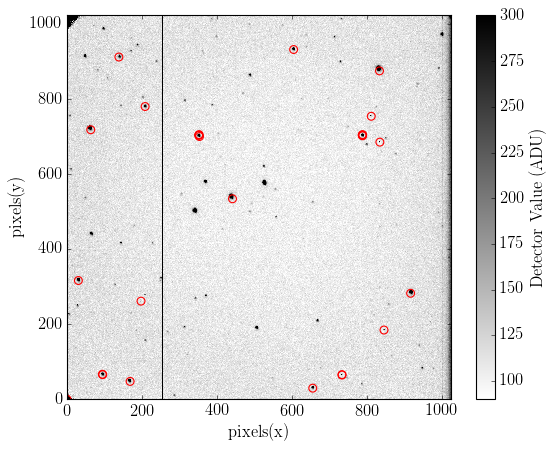

In [247]:
star_pts = findStar(red, percentile=99.6)
xpts, ypts = [], []
for p in star_pts:
    if (p[1] != 255) & (p[1] != 256) & (p[1] < 1000):
        xpts.append(p[0])
        ypts.append(p[1])
pts = np.array([ypts, xpts])
ptlist = pts.T

clusters = []
clus = []
cpt = ptlist[0]
for i in range(len(ptlist)):
    if dist(cpt, ptlist[i]) < 20**2:
        clus.append(ptlist[i])
    else:
        cpt = ptlist[i+1]
        clusters.append(np.array(clus))
        clus = []

plotImg(red, pts=np.array([c[0] for c in np.array(clusters)]).T, rng=[90,300])

In [254]:
clusters[2]

array([[168,  48],
       [169,  48],
       [165,  49],
       [166,  49],
       [167,  49],
       [168,  49],
       [169,  49],
       [164,  50],
       [165,  50],
       [166,  50],
       [167,  50],
       [168,  50],
       [169,  50],
       [165,  51],
       [166,  51],
       [167,  51],
       [168,  51],
       [169,  51],
       [165,  52],
       [166,  52],
       [167,  52],
       [168,  52]])

In [223]:
def dist(r1, r2):
    return np.sqrt((r1[0]-r2[0])**2 + (r1[1]-r2[1])**2)

array([[   0,  655,  168,  733,   95,  733,   94,  845,  505,  668,  197,
         207,  916,   30,   65,  341,  441,  529,  369,  523,  368,  524,
         368,  525,  368,  526,  369,  834,  353,  788,  351,  787,  351,
         787,  352,  788,   63,  811,  208,  487,  833,  138,   48,  139,
          48,  140,   48,   48,  604,  998,   98,   98,    1,    1,    1,
          23,    2,   23,    1,   26,    2,   25,    1,   24,    3,   24,
           3,   24,    2,   24,    1,   23,    3],
       [   0,   30,   48,   65,   66,   66,   67,  185,  190,  210,  262,
         278,  283,  317,  440,  499,  535,  572,  579,  579,  580,  580,
         581,  581,  582,  582,  583,  685,  701,  703,  704,  704,  705,
         705,  706,  706,  719,  755,  781,  865,  876,  913,  914,  914,
         915,  915,  916,  917,  933,  972,  988,  989,  991, 1006, 1011,
        1012, 1013, 1015, 1016, 1016, 1017, 1017, 1018, 1018, 1019, 1019,
        1020, 1020, 1021, 1021, 1022, 1022, 1023]])